In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# plotting defaults
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True

# find data folder (works whether the notebook is in ./notebooks or deeper)
candidate_dirs = [Path("../data"), Path("../../data"), Path("data")]
DATA_DIR = next((d for d in candidate_dirs if d.exists()), None)
if DATA_DIR is None:
    raise FileNotFoundError("Couldn't find a 'data' folder relative to this notebook.")

CLEAN_FILE = DATA_DIR / "cleaned_readmissions.csv"
if not CLEAN_FILE.exists():
    raise FileNotFoundError(f"Missing cleaned file: {CLEAN_FILE}")

# load cleaned dataset
df = pd.read_csv(CLEAN_FILE)

# normalize column names to snake_case so later code is stable
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

print("Loaded:", CLEAN_FILE.resolve())
df.shape, df.head(3)

Loaded: /Users/meghanakurapati/Documents/projects/healthcare-readmission-analytics/data/cleaned_readmissions.csv


((18510, 14),
                      facility_name  facility_id state          measure_id  \
 0  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL   READM-30-AMI-HRRP   
 1  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL  READM-30-CABG-HRRP   
 2  SOUTHEAST HEALTH MEDICAL CENTER        10001    AL    READM-30-HF-HRRP   
 
     score  predicted_readmission_rate  expected_readmission_rate  \
 0  0.9483                     13.0146                    13.7235   
 1  0.9509                      9.6899                    10.1898   
 2  1.0597                     21.5645                    20.3495   
 
    number_of_discharges  number_of_readmissions  start_date    end_date  \
 0                 296.0                    36.0  2020-07-01  2023-06-30   
 1                 151.0                    13.0  2020-07-01  2023-06-30   
 2                 681.0                   151.0  2020-07-01  2023-06-30   
 
    footnote risk_band                    condition  
 0       NaN       Low  Acute Myoc

In [53]:
def make_unique(cols):
    seen = {}
    out = []
    for c in cols:
        if c not in seen:
            seen[c] = 0
            out.append(c)
        else:
            seen[c] += 1
            out.append(f"{c}__{seen[c]}")  # append a suffix for duplicates
    return out

df.columns = make_unique(df.columns)

# 1) choose a metric column and call it `score`
#    try these in order; rename whichever we find first
metric_priority = ["excess_readmission_ratio", "predicted_readmission_rate", "score"]
metric_found = next((c for c in metric_priority if c in df.columns), None)
if metric_found is None:
    raise ValueError(
        "No metric column found. Expected one of: "
        + ", ".join(metric_priority)
    )

# if the metric isn't already named 'score', create it
if metric_found != "score":
    df["score"] = df[metric_found]

# 2) convert numeric-like columns safely, even if duplicates exist
base_numeric = {
    "score",
    "number_of_discharges",
    "number_of_readmissions",
    "predicted_readmission_rate",
    "expected_readmission_rate",
}
for col in df.columns:
    base = col.split("__")[0]  # strip duplicate suffix like "__1"
    if base in base_numeric:
        # only convert 1-D Series (now always true since columns are unique)
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 3) parse dates (handle possible duplicates like start_date__1)
for col in df.columns:
    base = col.split("__")[0]
    if base in {"start_date", "end_date"}:
        df[col] = pd.to_datetime(df[col], errors="coerce")

# 4) facility_id as zero-padded string if present (handle dupes too)
for col in df.columns:
    if col.split("__")[0] == "facility_id":
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(".0", "", regex=False)
            .str.zfill(6)
        )

df.head(3)

,facility_name,facility_id,state,measure_id,score,score__1,expected_readmission_rate,number_of_discharges,number_of_readmissions,start_date,end_date,footnote,risk_band,condition
0,SOUTHEAST HEALTH MEDICAL CENTER,010001,AL,READM-30-AMI-HRRP,0.9483,13.0146,13.7235,296.0,36.0,2020-07-01,2023-06-30,NaN,Low,Acute Myocardial Infarction
1,SOUTHEAST HEALTH MEDICAL CENTER,010001,AL,READM-30-CABG-HRRP,0.9509,9.6899,10.1898,151.0,13.0,2020-07-01,2023-06-30,NaN,Low,CABG
2,SOUTHEAST HEALTH MEDICAL CENTER,010001,AL,READM-30-HF-HRRP,1.0597,21.5645,20.3495,681.0,151.0,2020-07-01,2023-06-30,NaN,High,Heart Failure


In [54]:
display(df.info())
display(df.isna().mean().sort_values(ascending=False).head(10))

summary = {
    "rows": len(df),
    "hospitals": df["facility_id"].nunique() if "facility_id" in df.columns else None,
    "states": df["state"].nunique() if "state" in df.columns else None,
    "measures": (df["measure_name"].nunique() if "measure_name" in df.columns
                 else df["measure_id"].nunique() if "measure_id" in df.columns
                 else None),
    "avg_score": round(df["score"].mean(), 4) if "score" in df.columns else None,
}
summary


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18510 entries, 0 to 18509
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   facility_name              18510 non-null  object        
 1   facility_id                18510 non-null  object        
 2   state                      18510 non-null  object        
 3   measure_id                 18510 non-null  object        
 4   score                      11927 non-null  float64       
 5   score__1                   11927 non-null  float64       
 6   expected_readmission_rate  11927 non-null  float64       
 7   number_of_discharges       8340 non-null   float64       
 8   number_of_readmissions     8121 non-null   float64       
 9   start_date                 18510 non-null  datetime64[ns]
 10  end_date                   18510 non-null  datetime64[ns]
 11  footnote                   6583 non-null   float64       
 12  risk

None

footnote                     0.644354
number_of_readmissions       0.561264
number_of_discharges         0.549433
score                        0.355646
score__1                     0.355646
expected_readmission_rate    0.355646
risk_band                    0.355646
facility_name                0.000000
facility_id                  0.000000
state                        0.000000
dtype: float64

{'rows': 18510,
 'hospitals': 3085,
 'states': 51,
 'measures': 6,
 'avg_score': np.float64(1.0017)}

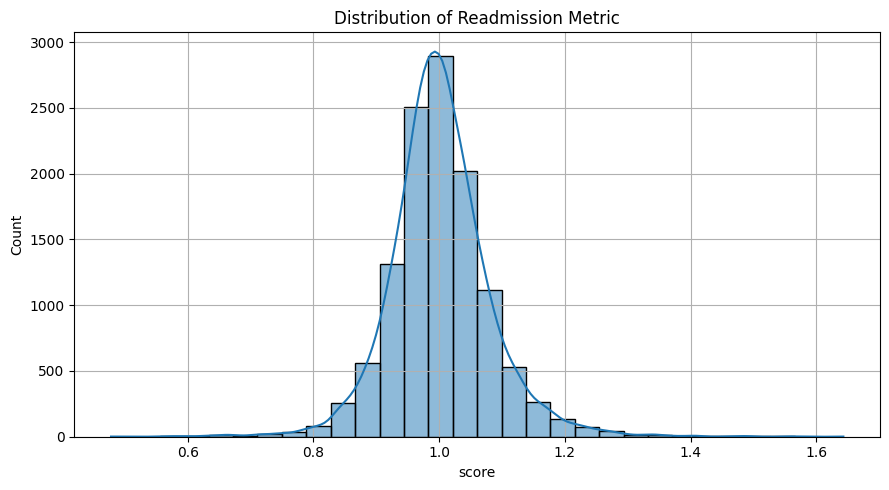

In [55]:
sns.histplot(df["score"].dropna(), bins=30, kde=True)
plt.title("Distribution of Readmission Metric")
plt.xlabel("score")
plt.tight_layout()
plt.show()

measure_id
READM-30-HIP-KNEE-HRRP    1.0038
READM-30-AMI-HRRP         1.0019
READM-30-COPD-HRRP        1.0017
READM-30-PN-HRRP          1.0012
READM-30-HF-HRRP          1.0012
READM-30-CABG-HRRP        1.0007
Name: score, dtype: float64

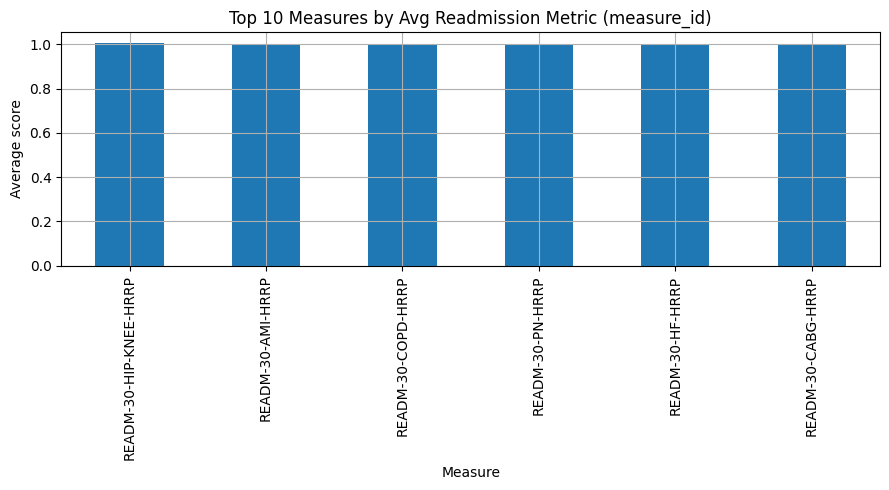

In [56]:
measure_col = "measure_name" if "measure_name" in df.columns else ("measure_id" if "measure_id" in df.columns else None)

if measure_col is not None:
    top_measures = (
        df.groupby(measure_col, dropna=False)["score"]
          .mean()
          .sort_values(ascending=False)
          .head(10)
          .round(4)
    )
    display(top_measures)

    ax = top_measures.plot(kind="bar")
    ax.set_title(f"Top 10 Measures by Avg Readmission Metric ({measure_col})")
    ax.set_ylabel("Average score")
    ax.set_xlabel("Measure")
    plt.tight_layout()
    plt.show()
else:
    print("No 'measure_name' or 'measure_id' column found; skipping measure analysis.")

state
MA    1.0409
NJ    1.0278
IL    1.0201
DC    1.0197
FL    1.0193
NV    1.0189
WV    1.0157
VT    1.0117
KY    1.0107
CA    1.0104
MS    1.0104
AL    1.0099
NY    1.0084
GA    1.0080
MI    1.0075
Name: score, dtype: float64

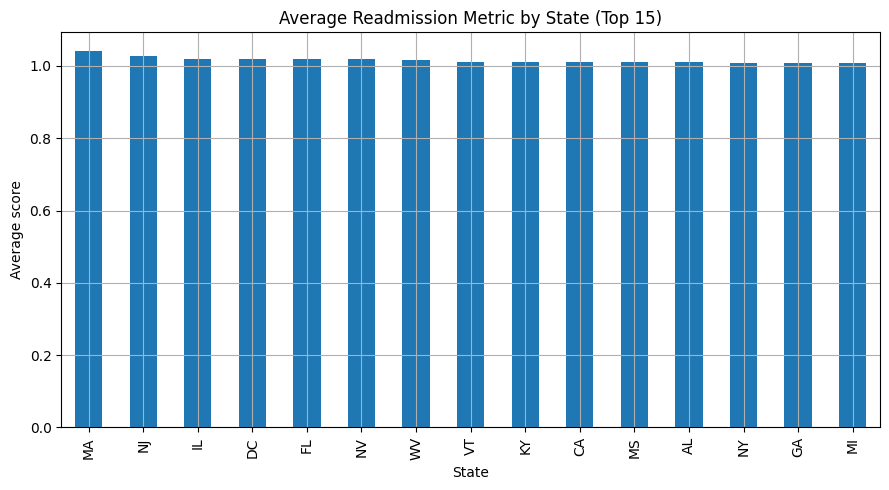

In [57]:
if {"state", "score"}.issubset(df.columns):
    state_avg = (
        df.groupby("state", dropna=False)["score"]
          .mean()
          .sort_values(ascending=False)
          .head(15)
          .round(4)
    )
    display(state_avg)

    ax = state_avg.plot(kind="bar")
    ax.set_title("Average Readmission Metric by State (Top 15)")
    ax.set_ylabel("Average score")
    ax.set_xlabel("State")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'state' not found; skipping state comparison.")

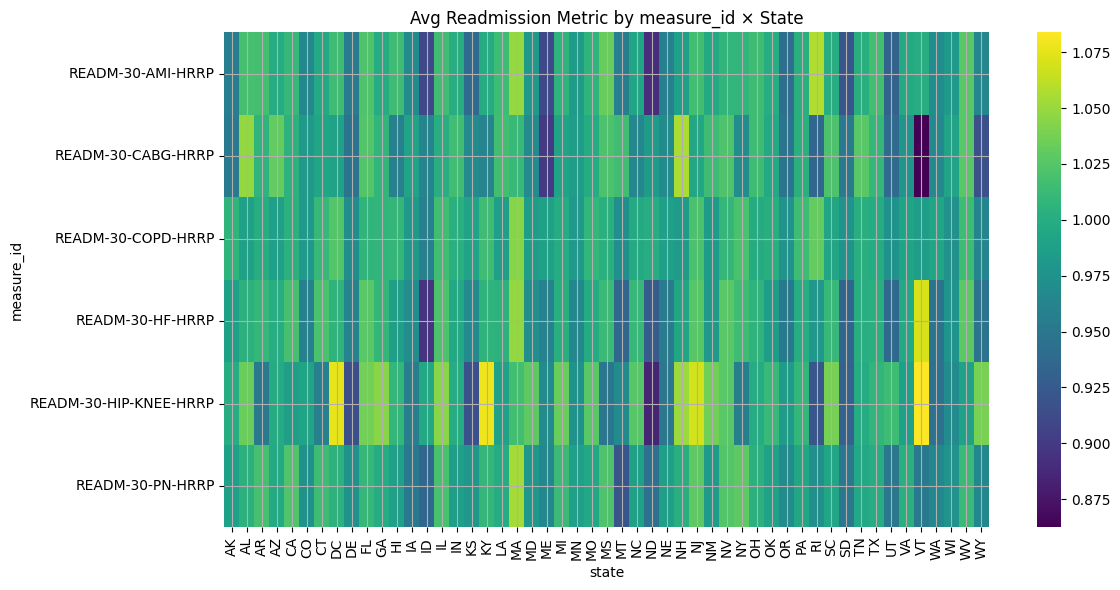

In [58]:
if (("state" in df.columns) and (measure_col is not None)):
    pivot = df.pivot_table(values="score", index=measure_col, columns="state", aggfunc="mean")
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, cmap="viridis")
    plt.title(f"Avg Readmission Metric by {measure_col} × State")
    plt.tight_layout()
    plt.show()
else:
    print("Need both a measure column and 'state' to draw heatmap; skipping.")

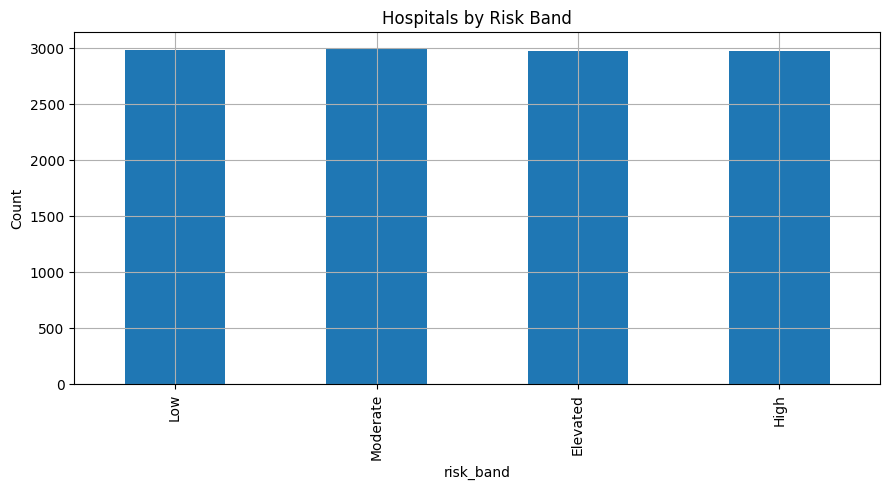

In [59]:
if "score" in df.columns and df["score"].notna().sum() >= 4:
    df["risk_band"] = pd.qcut(df["score"], q=4, labels=["Low","Moderate","Elevated","High"])
    ax = df["risk_band"].value_counts().reindex(["Low","Moderate","Elevated","High"]).plot(kind="bar")
    ax.set_title("Hospitals by Risk Band")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric 'score' values to compute risk bands; skipping.")

In [62]:
IMG_DIR = Path("../dashboard/screenshots")
IMG_DIR.mkdir(parents=True, exist_ok=True)

# 9a) score distribution
sns.histplot(df["score"].dropna(), bins=30, kde=True)
plt.title("Distribution of Readmission Metric")
plt.xlabel("score")
plt.tight_layout()
plt.savefig(IMG_DIR / "score_distribution.png", dpi=160, bbox_inches="tight")
plt.close()

# 9b) top measures
if "top_measures" in globals():
    ax = top_measures.plot(kind="bar")
    ax.set_title(f"Top 10 Measures by Avg Readmission Metric ({measure_col})")
    ax.set_ylabel("Average score")
    ax.set_xlabel("Measure")
    plt.tight_layout()
    plt.savefig(IMG_DIR / "top_measures_by_score.png", dpi=160, bbox_inches="tight")
    plt.close()

# 9c) state averages
if "state_avg" in globals():
    ax = state_avg.plot(kind="bar")
    ax.set_title("Average Readmission Metric by State (Top 15)")
    ax.set_ylabel("Average score")
    ax.set_xlabel("State")
    plt.tight_layout()
    plt.savefig(IMG_DIR / "state_avg_score_top15.png", dpi=160, bbox_inches="tight")
    plt.close()

# 9d) heatmap
if (("state" in df.columns) and (measure_col is not None)):
    pivot = df.pivot_table(values="score", index=measure_col, columns="state", aggfunc="mean")
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, cmap="viridis")
    plt.title(f"Avg Readmission Metric by {measure_col} × State")
    plt.tight_layout()
    plt.savefig(IMG_DIR / "heatmap_measure_state.png", dpi=160, bbox_inches="tight")
    plt.close()

IMG_DIR, list(IMG_DIR.glob("*.png"))

(PosixPath('../dashboard/screenshots'),
 [PosixPath('../dashboard/screenshots/state_avg_score_top15.png'),
  PosixPath('../dashboard/screenshots/top_measures_by_score.png'),
  PosixPath('../dashboard/screenshots/heatmap_measure_state.png'),
  PosixPath('../dashboard/screenshots/score_distribution.png')])